In [1]:
import numpy as np
np.bool = np.bool_
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib as mt
import matplotlib.pyplot as plt
import MDAnalysis as mda
import sys
sys.path.append('../../0_python_modules/')
import msm_analysis as ana
import idp_analysis as idp

In [2]:
n_clus = np.array([20, 30, 50, 70, 100, 150, 250, 350, 500, 700, 1000, 1500])
msm_lags = np.arange(5,70+1,5)
n_pcca = np.array([2, 3, 4, 5, 6])

In [3]:
def get_msm_labels(diff, nc, ml, npc):
    out = []
    for i in range(len(nc)):
        for j in range(len(ml)):
            for k in range(len(npc)):
                out.append([ nc[i], ml[j], npc[k], diff[i,j,k] ])
    return np.array(out)

In [4]:
def get_frames(mdis, dtrj, stds, 
               microstate='large',):
    frames = []
    for a,macro in enumerate(mdis):
        if microstate=='large':
            micro = macro[ stds[macro].argmax() ]
        else:
            micro = macro[ stds[macro].argmin() ]
            
        nframes = np.where(dtrj==micro)
        frames.append(nframes[0])
        
    return frames

def write_frames(pdb, trajs, idata,
                 fid, nconfs=10, otype='random', sel='all', sel2='all',
                ofmt='pdb', opath='./', oname='frame'):
    
    uni = mda.Universe(f'{pdb}', f'{trajs}')
    
    dd = idata[fid]
    
    if otype=='random':
        np.random.seed(0)
        oframes = np.random.choice(fid, nconfs)
    elif otype == 'min':
        oframes = fid[dd.argsort()[:nconfs]]
    elif otype == 'max':
        oframes = fid[dd.argsort()[::-1][:nconfs]]
    elif otype == 'variable':
        oframes = fid[dd.argsort()[::int(len(fid)/nconfs)][:nconfs]]
    else:
        raise ValueError(f'{otype} not in [random, variable, min, max]')
        
    for a,i in enumerate(oframes):
        uni.trajectory[i]
        aa = uni.select_atoms(f'{sel}')
        aa = aa.translate(-uni.select_atoms(sel2).center_of_mass())
        aa.write(f'{opath}{oname}{a}.{ofmt}')

In [5]:
colors = np.array(['salmon', 'dodgerblue', 'teal', 'limegreen', 'sienna', 'violet'])
cmaps = [mt.colors.LinearSegmentedColormap.from_list('', colors[:i], N=i) for i in range(2, 7)]

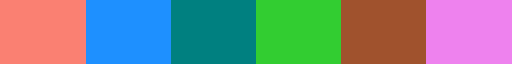

In [6]:
cmaps[4]

In [7]:
trajs = '../../1_datasets/idp_rg/pnas2018b-asyn-a99SBdisp-extended-protein-combined.xtc'
pdb = '../../1_datasets/idp_rg/DESRES-Trajectory_pnas2018b-asyn-a99SBdisp-extended-protein.pdb'

In [8]:
idata1 = np.loadtxt('../../1_datasets/idp_rg/rg_system.xvg', comments=['@','#'])[:,1]
idata2 = np.loadtxt('../../1_datasets/idp_rg/dist_ca_10-130.xvg', comments=['@','#'])[:,1]

In [9]:
durf = np.load('urf/saved_fdiffs/cmean_strict.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    d1 = d1[d1[:,2]==6]
    print(i, np.round(d1[d1[:,3].argmax()], 2) )

0 [700.     5.     6.    45.83]
1 [100.  20.   6.  86.]
2 [150.    70.     6.    68.33]
3 [20.  30.   6.  64.2]
4 [20.    5.    6.   56.13]


In [10]:
durf = np.load('urf/saved_dbi/dbi.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    d1 = d1[d1[:,2]==6]
    print(i, np.round(d1[d1[:,3].argmax()], 2) )

0 [250.     5.     6.     3.88]
1 [100.    30.     6.     4.03]
2 [30.    5.    6.    3.31]
3 [20.   15.    6.    3.56]
4 [100.    55.     6.     2.78]


## i=2, cl=150, ml=70, pc=6

In [14]:
i=2
cl = 150
ml = 70
pc = 6

tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([  7,  38,  43,  46,  64,  73,  84,  91, 113]),
 array([  1,  21,  25,  26,  34,  44,  67,  81,  93,  98, 101, 102, 143]),
 array([  6,  28,  54,  59,  87, 107, 117, 121, 125, 136]),
 array([  5,  17,  41,  42,  49,  63,  66,  74,  80,  89,  90,  96, 126,
        135, 139, 141, 144, 149]),
 array([  4,   9,  14,  24,  29,  31,  39,  47,  51,  57,  60,  65,  69,
         75,  77,  79,  86,  94, 100, 103, 111, 132, 138, 140, 145, 146]),
 array([  0,   2,   3,   8,  10,  11,  12,  13,  15,  16,  18,  19,  20,
         22,  23,  27,  30,  32,  33,  35,  36,  37,  40,  45,  48,  50,
         52,  53,  55,  56,  58,  61,  62,  68,  70,  71,  72,  76,  78,
         82,  83,  85,  88,  92,  95,  97,  99, 104, 105, 106, 108, 109,
        110, 112, 114, 115, 116, 118, 119, 120, 122, 123, 124, 127, 128,
        129, 130, 131, 133, 134, 137, 142, 147, 148])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


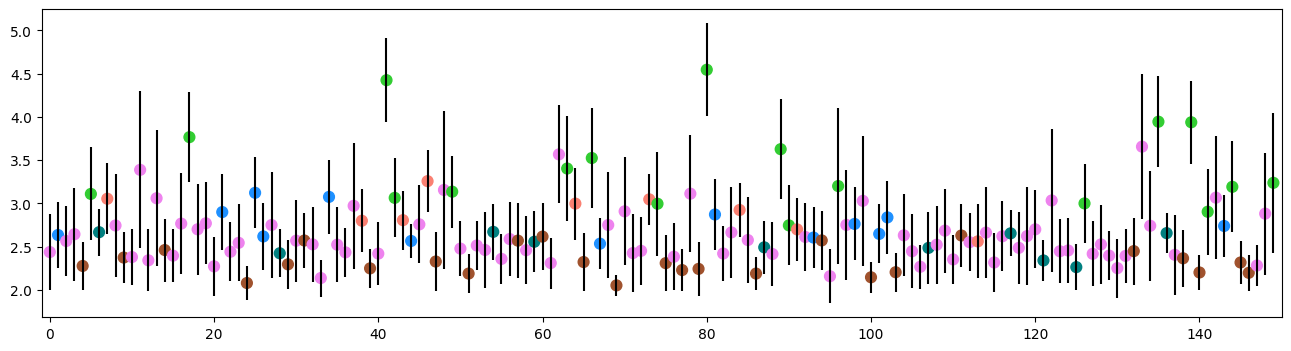

In [15]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()

mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

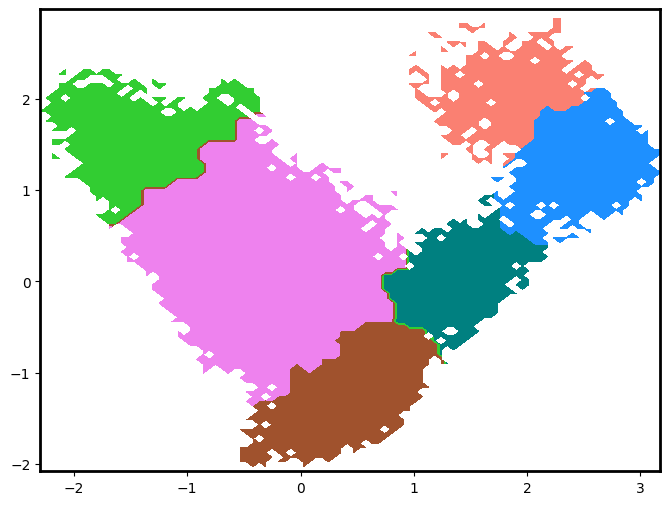

In [16]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

## i=4, cl=100, ml=55, pc=6

In [17]:
i=4
cl = 100
ml = 55
pc = 6

tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([11, 16, 44, 52, 56, 98]),
 array([ 1,  8, 26, 30, 32, 39, 49, 67, 69, 74, 90, 96]),
 array([ 5, 33, 66, 68]),
 array([ 2, 13, 19, 21, 24, 36, 40, 41, 47, 57, 58, 78, 83, 84, 93]),
 array([ 0,  4,  9, 15, 18, 22, 25, 29, 31, 37, 42, 45, 48, 50, 55, 63, 65,
        72, 73, 77, 81, 82, 86, 88, 89, 91]),
 array([ 3,  6,  7, 10, 12, 14, 17, 20, 23, 27, 28, 34, 35, 38, 43, 46, 51,
        53, 54, 59, 60, 61, 62, 64, 70, 71, 75, 76, 79, 80, 85, 87, 92, 94,
        95, 97, 99])]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


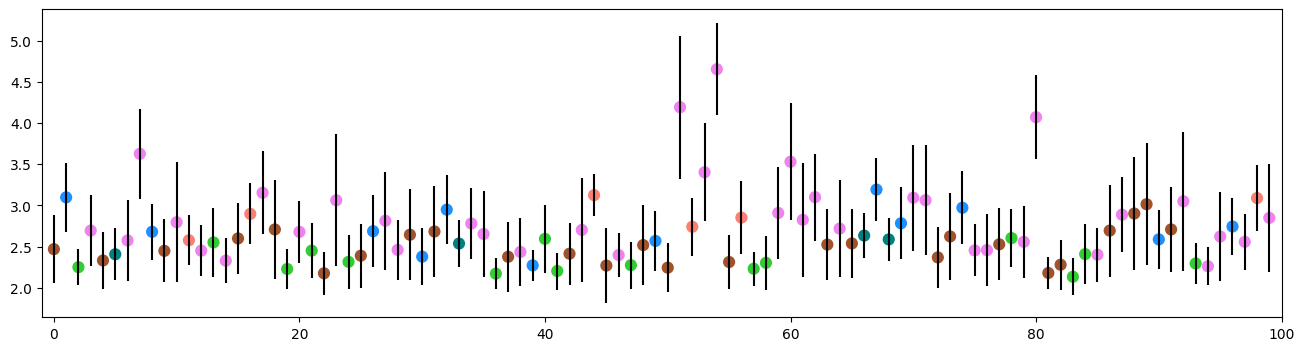

In [18]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()

mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

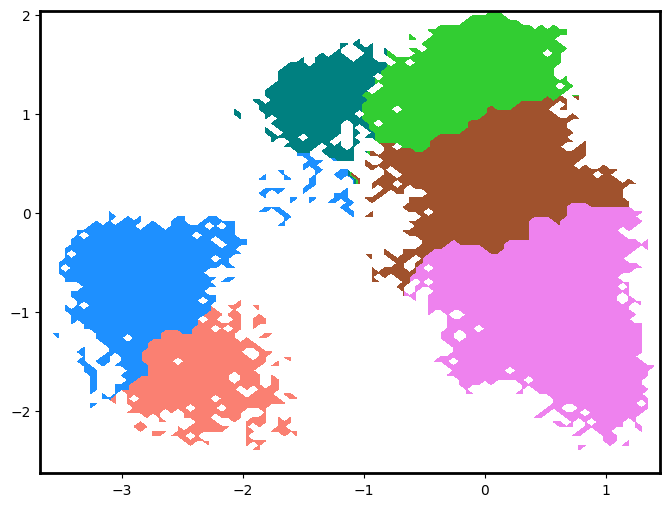

In [19]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

## bad

In [9]:
durf = np.load('urf/saved_fdiffs/cmean_strict.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    d1 = d1[d1[:,2]==6]
    print(i, np.round(d1[d1[:,3].argmin()], 2) )

0 [30.   45.    6.   29.73]
1 [500.   45.    6.   18.6]
2 [20.   5.   6.  50.2]
3 [1500.     65.      6.     32.87]
4 [1000.     70.      6.     29.07]


In [10]:
durf = np.load('urf/saved_dbi/dbi.npy')
for i in range(5):
    d1 = get_msm_labels(durf[i], n_clus, msm_lags, n_pcca)
    d1 = d1[d1[:,2]==6]
    print(i, np.round(d1[d1[:,3].argmin()], 2) )

0 [700.     5.     6.     2.15]
1 [250.    50.     6.     2.33]
2 [1500.     55.      6.      2.24]
3 [250.    60.     6.     2.58]
4 [1500.      5.      6.      2.38]


## i=1, cl=500, ml=45, pc=6

In [11]:
i=1
cl = 500
ml = 45
pc = 6

tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([], dtype=int64),
 array([  2,   5,   6,   9,  12,  13,  16,  18,  19,  24,  27,  33,  35,
         36,  39,  44,  46,  50,  53,  54,  56,  65,  66,  67,  68,  75,
         76,  78,  81,  84,  85,  86,  88,  91,  95,  97, 103, 106, 107,
        108, 110, 111, 113, 117, 125, 126, 128, 132, 133, 134, 135, 136,
        145, 146, 152, 153, 156, 157, 165, 166, 167, 168, 169, 171, 175,
        176, 180, 182, 185, 189, 191, 192, 193, 198, 201, 203, 204, 206,
        209, 212, 224, 227, 229, 230, 231, 237, 240, 244, 246, 249, 254,
        256, 257, 258, 259, 261, 264, 266, 271, 278, 281, 283, 284, 290,
        291, 295, 297, 298, 300, 302, 307, 309, 313, 314, 317, 318, 320,
        325, 326, 328, 330, 333, 335, 338, 339, 350, 356, 359, 361, 362,
        363, 367, 370, 375, 383, 387, 388, 393, 394, 395, 399, 405, 407,
        408, 409, 410, 412, 419, 421, 426, 429, 431, 432, 434, 439, 443,
        448, 449, 453, 454, 458, 459, 464, 468, 469, 474, 477, 481, 484,
        487, 490, 492, 496

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


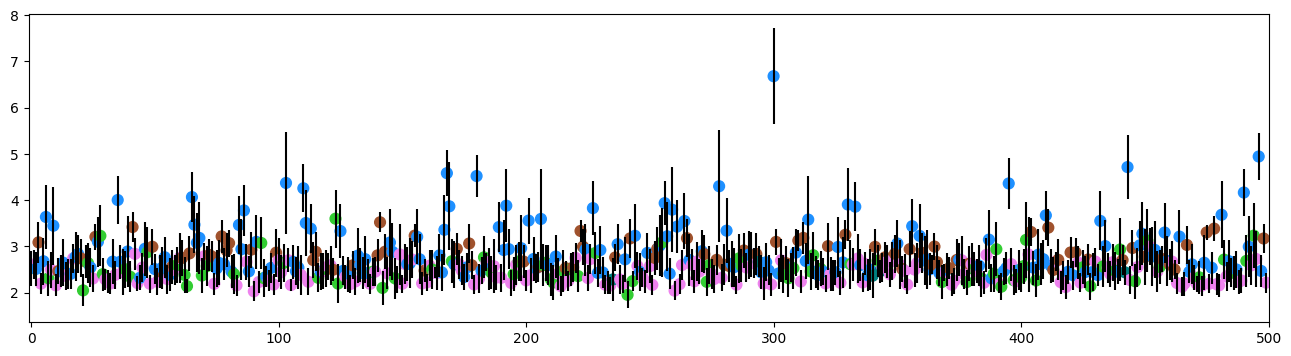

In [12]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()

mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

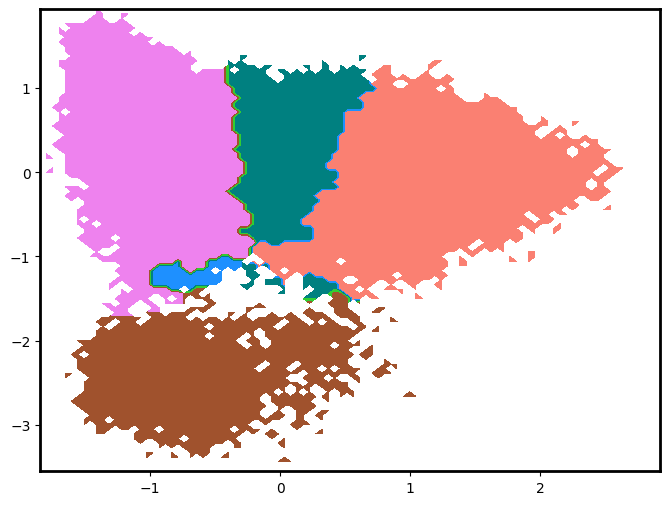

In [13]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
# plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()

## i=3, cl=250, ml=60, pc=6

In [14]:
i=3
cl = 250
ml = 60
pc = 6

tic2 = np.load(f'ticas/utic2_{i}.npy')

dtrj = np.load(f'urf/saved_msm3/dtraj_{i}_{cl}.npy')

model = msm.estimate_markov_model(dtrj, lag=ml)
model.pcca(pc)
mdis=model.metastable_sets
mdis

[array([ 81, 180, 228]),
 array([  1,   7,  12,  21,  22,  30,  38,  42,  48,  51,  54,  56,  82,
         84,  88,  93, 103, 106, 111, 113, 120, 123, 135, 154, 155, 156,
        159, 162, 170, 177, 178, 190, 203, 210, 214, 232, 234, 236, 242,
        249]),
 array([  5,  19,  44,  65,  77, 101, 114, 137, 146, 204, 226, 237]),
 array([  2,   6,   9,  13,  26,  32,  33,  40,  41,  43,  45,  46,  47,
         52,  61,  64,  66,  68,  70,  76,  78,  80,  96,  97, 104, 107,
        108, 109, 110, 116, 128, 130, 133, 138, 139, 140, 143, 144, 148,
        149, 150, 153, 158, 161, 165, 183, 188, 189, 195, 198, 200, 201,
        202, 212, 213, 217, 218, 221, 222, 227, 231, 235, 239, 245]),
 array([  0,   3,   8,  10,  11,  15,  18,  20,  24,  25,  28,  31,  35,
         36,  37,  39,  50,  55,  57,  59,  62,  63,  69,  71,  73,  74,
         75,  79,  83,  85,  87,  89,  90,  91,  92,  95, 100, 102, 105,
        112, 117, 119, 122, 124, 125, 126, 127, 142, 145, 147, 151, 152,
        157, 160,

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


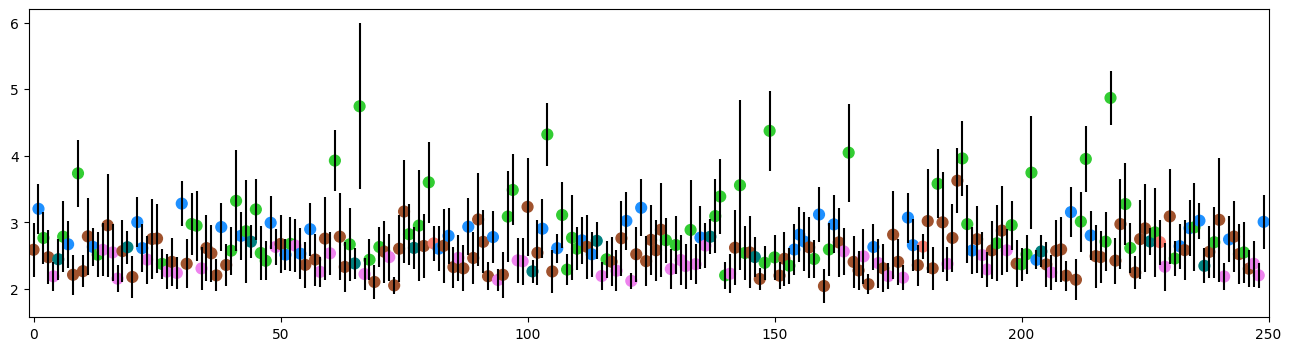

In [15]:
pr = ana.analyze_msm_clusters([dtrj])
pr.take_data([idata1])
means, stds, probs = pr.get_mean()

mcolors = np.zeros((cl))
for a,k in enumerate(model.metastable_sets):
    mcolors[k] = a
    
fig,ax=plt.subplots(1, figsize=(16,4))
ax.errorbar(range(cl), means, fmt='.', yerr=stds, ms=0, ecolor='black')
ax.scatter(range(cl), means, c=colors[mcolors.astype(int)], s=60)
ax.set_xlim(-1,cl)
plt.show()

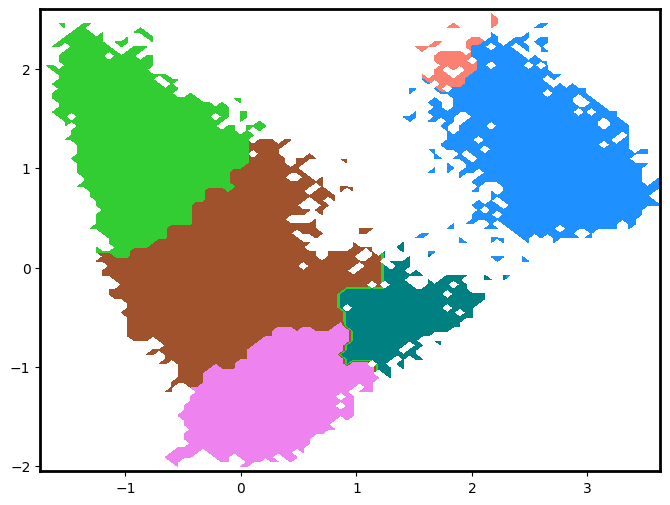

In [16]:
fig,ax=plt.subplots(1,figsize=(8,6))
mplt.plot_state_map(tic2[:,0], tic2[:,1],
                   model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                   cbar=False, cmap=cmaps[pc-2], ax=ax)
ax.spines[:].set_linewidth(2)
# plt.savefig(f'plots/statemap_{i}_{cl}_{ml}_{pc}.pdf')
plt.show()